# Module Project
## Synthesizing raw audio signals to sound like saxophone sounds

In [6]:
pip install librosa

  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 3.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 4.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.9 MB/s eta 0:00:00
Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (10.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.1/413.1 kB 6.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 8.9 MB/s eta 0:00:0000:0100:01m
Using cached re

In [33]:
import numpy as np
from scipy.io import wavfile
import librosa, librosa.display
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
%run Util.ipynb
%matplotlib inline
import IPython.display as ipd

/var/folders/wz/njd4pyh975g7stkhmhcy2frr0000gn/T/ipykernel_12460/3664934314.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


In [12]:
# Get middle C frequency
note_freqs = get_music_notes()
frequency = note_freqs['C4']

# Pure sine wave
sine_wave = get_sine_wave(frequency, duration=2, amplitude=2048)
wavfile.write('data/pure_c.wav', rate=44100, data=sine_wave.astype(np.int16))

In [34]:
print(frequency)

261.6255653005986


### Visualising pure c4


In [16]:
sample_rate, middle_c = wavfile.read('data/pure_c.wav')

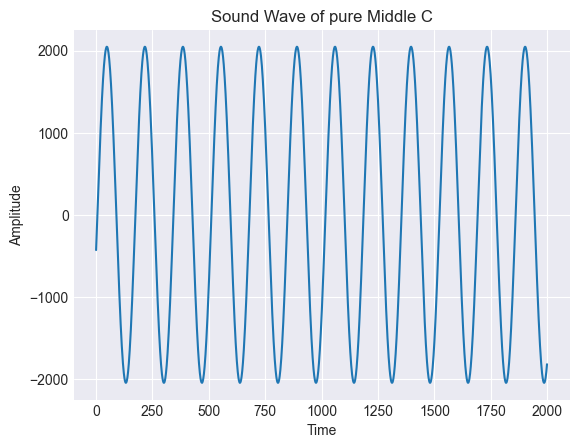

In [17]:
plt.plot(middle_c[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of pure Middle C')
plt.grid()

In [21]:
ipd.Audio(middle_c, rate=44100, normalize=True)

### Visualising saxophone c4

In [25]:
sax_sample_rate, sax_middle_c = wavfile.read('data/sax_c.wav')

In [26]:
sax_middle_c

array([-26, -29, -34, ..., 671, 686, 700], dtype=int16)

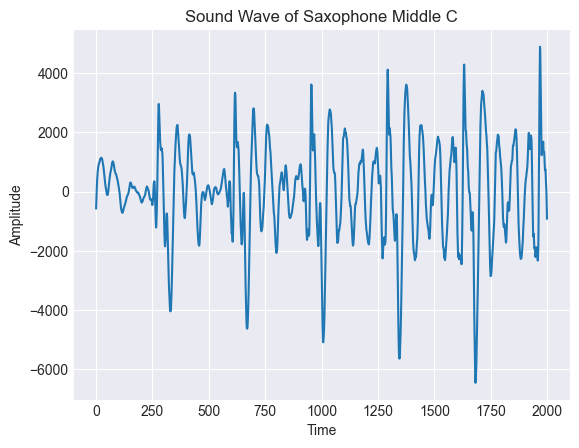

In [32]:
plt.plot(sax_middle_c[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of Saxophone Middle C')
plt.grid()

In [28]:
ipd.Audio(sax_middle_c, rate=sax_sample_rate, normalize=True)

### FFT

In [29]:
t = np.arange(sax_middle_c.shape[0])
freq = np.fft.fftfreq(t.shape[-1]) * sax_sample_rate
sp = np.fft.fft(sax_middle_c)

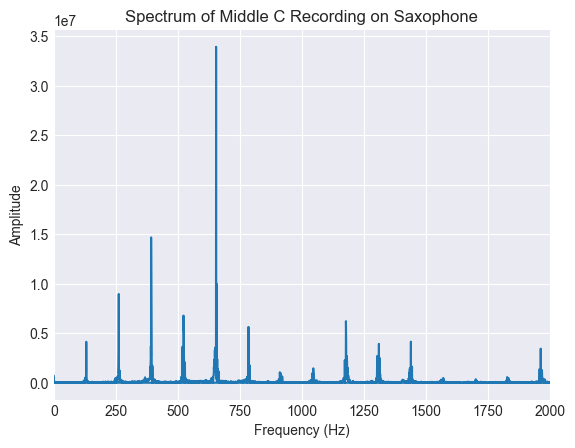

In [31]:
# Plot spectrum
plt.plot(freq, abs(sp.real))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum of Middle C Recording on Saxophone')
plt.xlim((0, 2000))
plt.grid()
plt.savefig('data/spectrum.jpg')

Notes on this graph:
<br>
- The notes are evenly-spaced
- They occur just under every 250/2 frequency samples

<br>

We need to create factors of the dominant frequency against the actual frequency. We then use this to create overtones

In [35]:
# Get positive frequencies
idx = np.where(freq > 0)[0]
freq = freq[idx]
sp = sp[idx]

# Get dominant frequencies
sort = np.argsort(-abs(sp.real))[:100]
dom_freq = freq[sort]

In [36]:
# Calculate the frequency ratios and amplitude ratios for the saxophone note
freq_ratio = np.round(dom_freq / frequency)
unique_freq_ratio = np.unique(freq_ratio)
amp_ratio = abs(sp.real[sort] / np.sum(sp.real[sort]))

In [37]:
# Construct the sax_factor
sax_factor = np.zeros((int(unique_freq_ratio[-1]), ))
for i in range(sax_factor.shape[0]):
    idx = np.where(freq_ratio == i + 1)[0]
    sax_factor[i] = np.sum(amp_ratio[idx])
sax_factor = sax_factor / np.sum(sax_factor)

In [40]:
# Now use the sax_factor with your apply_overtones function
sax_note_with_overtones = apply_saxophone_overtones(frequency, duration=2.0, sax_factor=sax_factor)

In [41]:
ipd.Audio(sax_note_with_overtones, rate=sax_sample_rate, normalize=True)

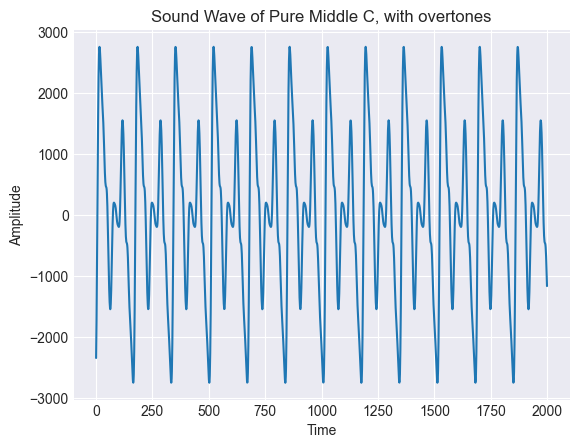

In [43]:
plt.plot(sax_note_with_overtones[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of Pure Middle C, with overtones')
plt.grid()

### Attack, Sustain, Decay, Release

Refs: https://www.youtube.com/watch?v=9SMi47AEnSo

<br>